In [131]:
import polars as pl
import json
# import os
from pathlib import Path
import altair as alt
import matplotlib.pyplot as plt
import numpy as np

In [89]:
def process_one_region(region):
    file_path = f'data/{region}.json'

    with open(file_path, 'r') as file:
        # Read in json data (one file for each region)
        data = json.load(file)
         
        # Convert json data to a list of dicts (to facilitate to conversion to a dataframe)
        records = [
            {
                'year': year,
                'named_storms': values[0],
                'named_storm_days': values[1],
                'hurricanes': values[2],
                'hurricane_days': values[3],
                'major_hurricanes': values[4],
                'major_hurricane_days': values[5],
                'ace': values[6],
            }
            for year, values in data.items()
        ]

        # Make a dataframe from the list-o-dicts
        df = (
            pl.DataFrame(records)
            .with_columns(
                # pl.lit(region).cast(pl.Categorical).alias('region'),
                pl.lit(region).alias('region'),
                pl.col('year').cast(pl.UInt16),
            )
        )

        # Put 'region" column first and scoot the rest to the right
        cols = df.columns
        cols = cols[-1:] + cols[:-1]

    return df[cols]

In [90]:
# Grab data from source .json files
data_dir = Path('data')
json_files = [file for file in data_dir.glob('*.json') if file.is_file()]

In [91]:
# Combine all region's pertinent data into one dataframe
df = pl.DataFrame()

for file in json_files:
    region = file.stem
    print(f'Processing the {region} region...')
    df = df.vstack(process_one_region(region))

df = (
    df
    .filter(
        pl.col('year').is_between(1980, 2023),
        ~pl.col('region').is_in(['global', 'northernhemisphere', 'southernhemisphere'])
    )
    .select(['region', 'year', 'major_hurricanes'])
)

Processing the northeastpacific region...
Processing the southindian region...
Processing the northatlantic region...
Processing the southernhemisphere region...
Processing the southpacific region...
Processing the northindian region...
Processing the global region...
Processing the northernhemisphere region...
Processing the northwestpacific region...


In [92]:
region_order = [
    'southindian',
    'southpacific',
    'northindian',
    'northwestpacific',
    'northeastpacific',
    'northatlantic',
]

In [93]:
region_colors = {
    'northwestpacific': '#15027d',
    'northeastpacific': '#4677a3',
    'northatlantic': '#34aa9f',
    'southindian': '#54dacb',
    'southpacific': '#648412',
    'northindian': '#cc9c09',
}

In [94]:
region_color_map = alt.Scale(
    domain=list(region_colors.keys()),
    range=list(region_colors.values())
)

In [95]:
# Make the chart
alt.Chart(df).mark_bar().encode(
    x=alt.X(
        'year',
        title='Year',
        scale=alt.Scale(domain=[1980, 2023])
    ),
    y='major_hurricanes',
    color=alt.Color(
        'region',
        title='Region',
        # sort=region_order,
        scale=region_color_map
    ),
    tooltip=['year', 'region', 'major_hurricanes']
)

alt.Chart(...)

### ISSUE
The `sort` parameter of the `color` encoding is not being honored.

Not matter what the sort order is specified as, the bars will always be stacked in alphabetical order!

Is it time to ditch altair?

### `matplotlib` chart

In [96]:
df

region,year,major_hurricanes
str,u16,i64
"""northeastpacific""",1980,3
"""northeastpacific""",1981,1
"""northeastpacific""",1982,5
"""northeastpacific""",1983,8
"""northeastpacific""",1984,7
…,…,…
"""northwestpacific""",2019,11
"""northwestpacific""",2020,7
"""northwestpacific""",2021,5


In [97]:
wide = df.pivot(on='year', values='major_hurricanes')

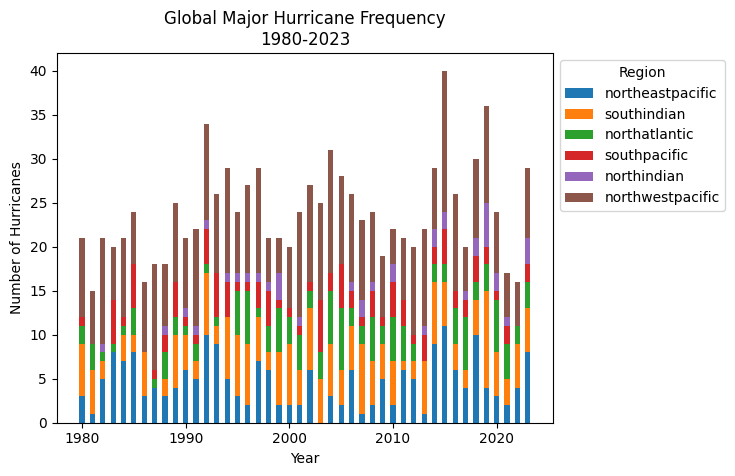

In [130]:
# years as tuple
years = tuple(df['year'].unique().to_list())

# region_hurricanes as dict {region: list of major_hurricane values}
region_hurricanes = {row[0]: list(row[1:]) for row in wide.rows()}

# calculate # of years 
n_years = len(years)

# initialize stack_bottom to np.zeros(n_years)
stack_bottom = np.zeros(n_years)

width = 0.5
fig, ax = plt.subplots()

for region, hurricanes in region_hurricanes.items():
    p = ax.bar(years, hurricanes, width, label=region, bottom=stack_bottom)
    stack_bottom += hurricanes

ax.set_title('Dude')
ax.legend(loc='upper left')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Number of Hurricanes')
plt.title('Global Major Hurricane Frequency\n1980-2023')
plt.legend(title='Region', loc='upper left', bbox_to_anchor=(1, 1))


plt.show()
    